#**Library & Dataset**

In [1]:
# Import Library

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from pylab import rcParams

In [2]:
# Membaca file CSV

df_order_items = pd.read_csv('/content/drive/MyDrive/order_items.csv')
df_users = pd.read_csv('/content/drive/MyDrive/users.csv')
df_orders = pd.read_csv('/content/drive/MyDrive/orders.csv')

## **Studi Kasus 1**


1.   **Sales forecast / peramalan**
2.   **Rekomendasi waktu terbaik untuk ekspansi pasar (apabila sales forecast menyatakan layak untuk ekspansi)**

In [3]:
df_order_items.head()

,id,order_id,user_id,product_id,inventory_item_id,status,created_at,shipped_at,delivered_at,returned_at,sale_price
0,59347,41038,33153,13606,160256,Shipped,2020-01-05 08:14:27+00:00,2020-01-06 20:56:00+00:00,NaN,NaN,2.5
1,101072,69979,56200,13606,272958,Shipped,2022-05-17 07:06:19+00:00,2022-05-19 10:42:00+00:00,NaN,NaN,2.5
2,63687,44006,35515,13606,171991,Complete,2021-01-21 04:56:58+00:00,2021-01-19 07:16:00+00:00,2021-01-22 03:38:00+00:00,NaN,2.5
3,16338,11275,9230,13606,44149,Cancelled,2022-05-31 08:55:48.353609+00:00,NaN,NaN,NaN,2.5
4,85756,59418,47846,13606,231665,Cancelled,2022-05-22 11:36:45+00:00,NaN,NaN,NaN,2.5


In [4]:
df_order_items.columns

Index(['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
       'status', 'created_at', 'shipped_at', 'delivered_at', 'returned_at',
       'sale_price'],
      dtype='object')

*   **created_at** : Berisi informasi kapan terjadinya penjualan.
*   **sales_price** : Berisi informasi harga jual. kolom ini dipilih karena merepresentasikan pendapatan yang diperoleh oleh perusahaan setiap dilakukannya transaksi.
*   **status** : status order



In [5]:
# drop kolom duplikat dan tidak dipakai

df_order_items.drop(columns=['id', 'order_id', 'user_id', 'product_id', 'inventory_item_id',
                            'shipped_at', 'delivered_at', 'returned_at'], inplace=True)

In [6]:
df_order_items.sample(10)

,status,created_at,sale_price
32334,Cancelled,2020-10-19 09:32:23+00:00,52.000000
645,Complete,2020-03-16 22:47:24+00:00,8.000000
179595,Processing,2020-01-29 08:08:04+00:00,31.330000
60117,Returned,2021-06-12 06:29:11+00:00,45.000000
121530,Processing,2020-10-21 11:29:13+00:00,35.990002
178130,Shipped,2021-08-02 11:10:24+00:00,27.219999
141296,Processing,2020-08-10 03:48:03+00:00,21.990000
119387,Shipped,2022-06-04 04:08:54.740248+00:00,54.990002
27814,Cancelled,2022-02-20 11:59:55+00:00,42.000000
2259,Shipped,2022-02-02 01:30:37+00:00,11.500000


In [7]:
df_order_items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 180508 entries, 0 to 180507
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   status      180508 non-null  object 
 1   created_at  180508 non-null  object 
 2   sale_price  180508 non-null  float64
dtypes: float64(1), object(2)
memory usage: 4.1+ MB


In [8]:
# lihat distribusi kolom 'status'

df_order_items['status'].value_counts().to_frame()

,count
status,
Shipped,54467
Complete,45283
Processing,36225
Cancelled,26781
Returned,17752


In [9]:
# Pilih hanya data dengan status shipped dan complete untuk memastikan bahwa Anda hanya menggunakan transaksi final dalam model forecasting

ramal = df_order_items[df_order_items['status'].isin(['Complete', 'Shipped'])]
ramal

,status,created_at,sale_price
0,Shipped,2020-01-05 08:14:27+00:00,2.50
1,Shipped,2022-05-17 07:06:19+00:00,2.50
2,Complete,2021-01-21 04:56:58+00:00,2.50
7,Shipped,2022-04-21 14:42:33+00:00,3.00
8,Shipped,2022-02-12 14:40:47+00:00,3.00
...,...,...,...
180499,Shipped,2019-10-09 00:49:17+00:00,9.32
180500,Complete,2021-03-15 07:56:47+00:00,9.32
180501,Complete,2022-03-14 10:48:55+00:00,9.32
180505,Shipped,2020-12-08 04:56:12+00:00,9.82


In [10]:
# lihat distribusi kolom 'status'

ramal['status'].value_counts().to_frame()

,count
status,
Shipped,54467
Complete,45283


In [11]:
ramal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99750 entries, 0 to 180506
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   status      99750 non-null  object 
 1   created_at  99750 non-null  object 
 2   sale_price  99750 non-null  float64
dtypes: float64(1), object(2)
memory usage: 3.0+ MB


In [12]:
# drop kolom status

ramal.drop(columns=['status'], inplace=True)

In [13]:
ramal

,created_at,sale_price
0,2020-01-05 08:14:27+00:00,2.50
1,2022-05-17 07:06:19+00:00,2.50
2,2021-01-21 04:56:58+00:00,2.50
7,2022-04-21 14:42:33+00:00,3.00
8,2022-02-12 14:40:47+00:00,3.00
...,...,...
180499,2019-10-09 00:49:17+00:00,9.32
180500,2021-03-15 07:56:47+00:00,9.32
180501,2022-03-14 10:48:55+00:00,9.32
180505,2020-12-08 04:56:12+00:00,9.82


In [14]:
# Mengecek apakah ada baris duplikat
duplicate_rows = ramal[ramal.duplicated()]

# Menampilkan jumlah baris duplikat
num_duplicates = duplicate_rows.shape[0]
print(f"Jumlah baris duplikat: {num_duplicates}")

# Menampilkan baris duplikat
duplicate_rows

Jumlah baris duplikat: 0


,created_at,sale_price


In [15]:
# Mengecek jumlah nilai hilang di setiap kolom

missing_values = ramal.isnull().sum()
print(missing_values)

created_at    0
sale_price    0
dtype: int64


In [16]:
# Mengubah tipe data 'created_at' menjadi datetime dengan format yang sesuai

ramal['created_at'] = pd.to_datetime(ramal['created_at'], format='ISO8601')

In [17]:
ramal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 99750 entries, 0 to 180506
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype              
---  ------      --------------  -----              
 0   created_at  99750 non-null  datetime64[ns, UTC]
 1   sale_price  99750 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1)
memory usage: 2.3 MB


In [18]:
# mengurutkan data sesuai waktu terjadinya transaksi

ramal = ramal.sort_values(by='created_at')

In [19]:
ramal

,created_at,sale_price
177615,2019-01-05 05:39:08+00:00,79.949997
6807,2019-01-08 04:16:03+00:00,18.000000
86853,2019-01-10 16:16:21+00:00,46.619999
9342,2019-01-12 14:41:16+00:00,22.000000
69963,2019-01-13 01:12:59+00:00,74.500000
...,...,...
77518,2022-06-06 16:18:37+00:00,95.000000
175297,2022-06-06 16:26:45.823756+00:00,40.599998
46033,2022-06-06 16:58:02.491071+00:00,65.000000
104994,2022-06-06 17:17:33.005180+00:00,12.990000


In [20]:
# remove timezone dari datetime

ramal['created_at']=ramal['created_at'].dt.tz_localize(None)

In [21]:
ramal

,created_at,sale_price
177615,2019-01-05 05:39:08.000000,79.949997
6807,2019-01-08 04:16:03.000000,18.000000
86853,2019-01-10 16:16:21.000000,46.619999
9342,2019-01-12 14:41:16.000000,22.000000
69963,2019-01-13 01:12:59.000000,74.500000
...,...,...
77518,2022-06-06 16:18:37.000000,95.000000
175297,2022-06-06 16:26:45.823756,40.599998
46033,2022-06-06 16:58:02.491071,65.000000
104994,2022-06-06 17:17:33.005180,12.990000


In [22]:
# Grouping data sesuai tanggal terjadinya transaksi

ramal = ramal.groupby(pd.Grouper(key='created_at', axis=0,freq='D')).sum()

ramal

,sale_price
created_at,
2019-01-05,79.949997
2019-01-06,0.000000
2019-01-07,0.000000
2019-01-08,18.000000
2019-01-09,0.000000
...,...
2022-06-02,39134.470086
2022-06-03,20155.870028
2022-06-04,13465.040039


In [23]:
ramal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1249 entries, 2019-01-05 to 2022-06-06
Freq: D
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   sale_price  1249 non-null   float64
dtypes: float64(1)
memory usage: 19.5 KB


In [24]:
# buang data yang bernilai 0

ramal = ramal[~ramal['sale_price'].isin ([0.0])]

ramal

,sale_price
created_at,
2019-01-05,79.949997
2019-01-08,18.000000
2019-01-10,46.619999
2019-01-12,22.000000
2019-01-13,91.650000
...,...
2022-06-02,39134.470086
2022-06-03,20155.870028
2022-06-04,13465.040039


In [25]:
ramal.describe()

,sale_price
count,1230.000000
mean,4847.765931
std,5303.466300
min,11.990000
25%,1354.754995
50%,3267.380005
75%,6487.942496
max,68431.859949


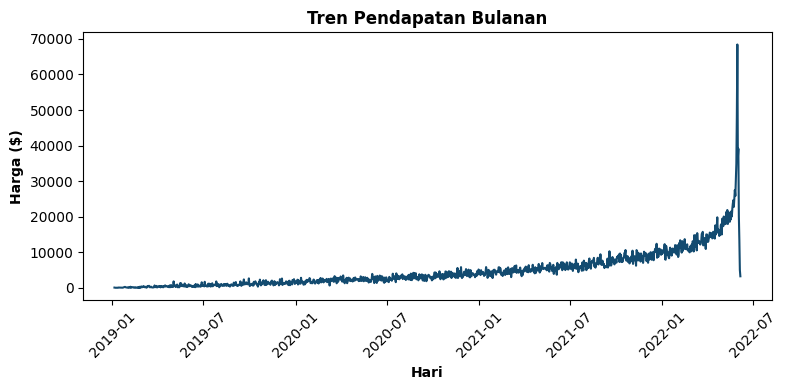

In [26]:
# Membuat plot tren penjualan
plt.figure(figsize=(8,4))
sns.lineplot(data=ramal, x='created_at', y='sale_price', color='#134B70')

# Menambahkan judul dan label dengan tulisan bold dan diperbesar
plt.title('Tren Pendapatan Bulanan', fontsize=12, fontweight='bold')
plt.xlabel('Hari', fontweight='bold')
plt.ylabel('Harga ($)', fontweight='bold')
plt.xticks(rotation=45)

# Menampilkan plot
plt.tight_layout()
plt.show()

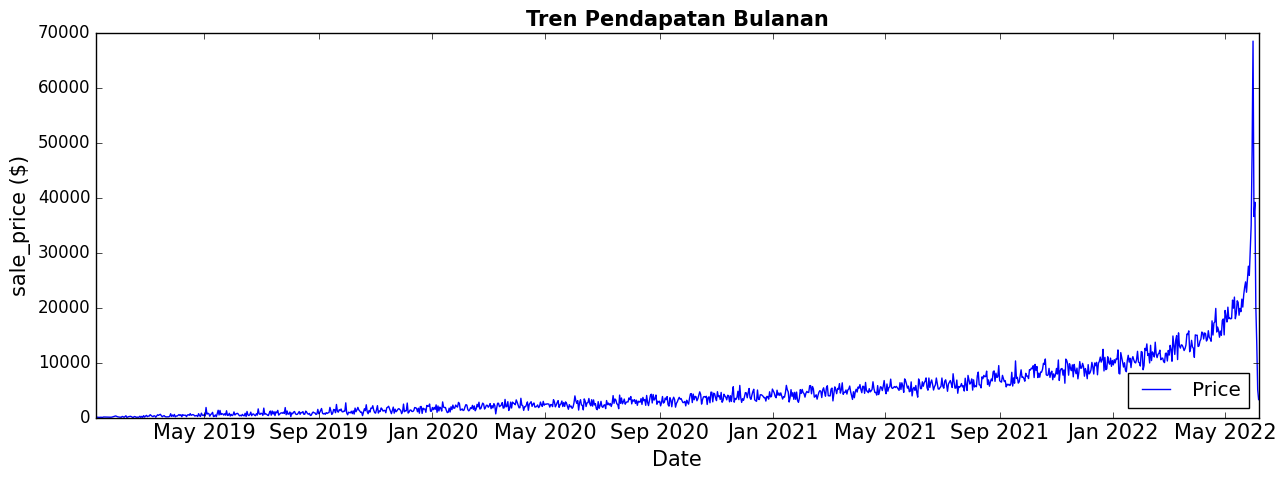

In [27]:
# function to plot time-series line graphs for each month

def plotfunc(df):
  plt.figure(figsize=(15, 5))
  plt.style.use('classic')
  rcParams['xtick.labelsize'] = 15

  #plt.subplot(1,2,1)
  plt.xlabel("Date", fontsize=15)
  plt.ylabel("sale_price ($)", fontsize=15)
  plt.title('Tren Pendapatan Bulanan', fontsize=15, fontweight='bold')
  plt.plot(df["sale_price"])
  plt.legend(['Price'],loc ="lower right")

  plt.show()

plotfunc(ramal)

###**Transformasi Data**

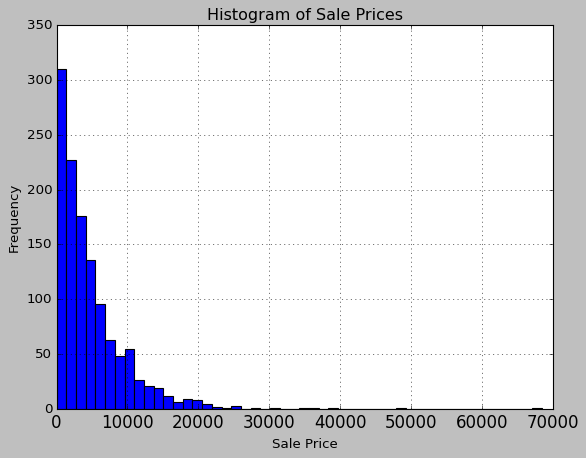

In [28]:
# Visualisasi histogram

ramal['sale_price'].hist(bins=50)
plt.title('Histogram of Sale Prices')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

In [29]:
from scipy.stats import skew

# Hitung skewness
skewness = skew(ramal['sale_price'].dropna())
print(f'Skewness: {skewness}')

Skewness: 3.4275037806421493


*   Skewness sebesar 3.43 menunjukkan bahwa data Anda memiliki skewness positif yang cukup tinggi, artinya data cenderung condong ke arah nilai yang lebih rendah dengan beberapa nilai ekstrem yang lebih tinggi.
*   Transformasi log sering digunakan untuk data yang skewed positif.



In [30]:
# Transformasi Log

ramal['sale_price_log'] = np.log(ramal['sale_price'] + 1)  # Menambahkan 1 untuk menghindari log(0)

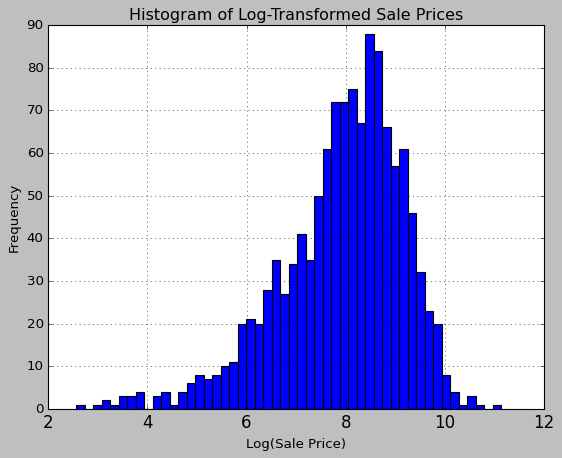

In [31]:
# Visualisasi histogram setelah transformasi

ramal['sale_price_log'].hist(bins=50)
plt.title('Histogram of Log-Transformed Sale Prices')
plt.xlabel('Log(Sale Price)')
plt.ylabel('Frequency')
plt.show()

In [32]:
# Hitung skewness lagi

skewness = skew(ramal['sale_price_log'].dropna())
print(f'Skewness: {skewness}')

Skewness: -0.9129460052908969


*   Skewness sebesar -0.91 menunjukkan bahwa data Anda memiliki skewness negatif, artinya data cenderung condong ke arah nilai yang lebih tinggi dengan beberapa nilai ekstrem yang lebih rendah. Ini berarti bahwa data Anda mungkin memiliki distribusi yang lebih berat di sisi kanan (nilai lebih tinggi) dan nilai-nilai ekstrem di sisi kiri.

*   Transformasi Yeo-Johnson adalah dapat menangani data dengan nilai nol atau negatif. Ini sering kali efektif untuk data dengan skewness negatif.

In [33]:
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='yeo-johnson')
ramal['sale_price_yeojohnson'] = pt.fit_transform(ramal[['sale_price_log']])

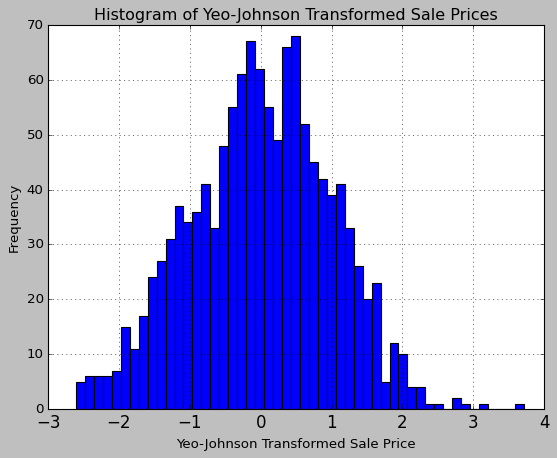

In [34]:
# Visualisasi Histogram untuk Yeo-Johnson

ramal['sale_price_yeojohnson'].hist(bins=50)
plt.title('Histogram of Yeo-Johnson Transformed Sale Prices')
plt.xlabel('Yeo-Johnson Transformed Sale Price')
plt.ylabel('Frequency')
plt.show()

In [35]:
# Hitung skewness lagi

skewness = skew(ramal['sale_price_yeojohnson'].dropna())
print(f'Skewness: {skewness}')

Skewness: -0.06454911750339451


Dengan nilai skewness sebesar -0.065, data Anda hampir simetris dan sangat dekat dengan distribusi normal. Ini berarti distribusi data tidak menunjukkan asimetri yang signifikan baik ke kiri maupun ke kanan.

In [36]:
ramal.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1230 entries, 2019-01-05 to 2022-06-06
Data columns (total 3 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   sale_price             1230 non-null   float64
 1   sale_price_log         1230 non-null   float64
 2   sale_price_yeojohnson  1230 non-null   float64
dtypes: float64(3)
memory usage: 38.4 KB


In [37]:
ramal.head(2)

,sale_price,sale_price_log,sale_price_yeojohnson
created_at,,,
2019-01-05,79.949997,4.393832,-2.171872
2019-01-08,18.000000,2.944439,-2.542745


In [38]:
# Memanggil kolom tertentu untuk analisis model
# Mengganti nama kolom

ramal = ramal[['sale_price_yeojohnson']].rename(columns={'sale_price_yeojohnson':'sale_price'})

ramal.head(2)

,sale_price
created_at,
2019-01-05,-2.171872
2019-01-08,-2.542745


### **Cek Stationaritas Data**

In [39]:
# Ho: It is non stationary
# H1: It is stationary

from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [40]:
target = ramal['sale_price']

In [41]:
adfuller_test(target)

ADF Test Statistic : -0.6833947528518942
p-value : 0.8510039153754597
#Lags Used : 19
Number of Observations Used : 1210
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [42]:
adfuller_test(target.diff()[1:])

ADF Test Statistic : -12.454406871834202
p-value : 3.516984774411568e-23
#Lags Used : 18
Number of Observations Used : 1210
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [43]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: None, order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

###**Pemodelan**

In [44]:
# Hitung jumlah data untuk data pelatihan (70%) dan data pengujian (30%)
train_size = int(len(target) * 0.7)
test_size = len(target) - train_size

# Bagi data menjadi data pelatihan dan data pengujian
target_train = target[:train_size]
target_test = target[train_size:]

# Cetak panjang masing-masing data
print("Jumlah data pelatihan:", len(target_train))
print("Jumlah data pengujian:", len(target_test))

Jumlah data pelatihan: 861
Jumlah data pengujian: 369


In [45]:
from itertools import product

p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 7

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [46]:
from tqdm import tqdm_notebook

# result_df = optimize_SARIMAX(endog=target_train, exog=exog_train, order_list=parameters_list, d=d, D=D, s=s)
result_df = optimize_SARIMAX(endog=target_train, exog=None, order_list=parameters_list, d=d, D=D, s=s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

,"(p,q,P,Q)",AIC
0,"(3, 3, 1, 1)",-68.595395
1,"(3, 3, 0, 0)",-66.693594
2,"(3, 3, 2, 1)",-66.130391
3,"(3, 3, 1, 2)",-65.665441
4,"(3, 3, 1, 3)",-65.502032
...,...,...
251,"(0, 2, 0, 0)",1191.198743
252,"(0, 0, 0, 2)",1191.858925
253,"(0, 1, 0, 0)",1537.077972
254,"(0, 0, 0, 1)",1537.847873


In [47]:
# variabel

p = 3
d = 0
q = 3
P = 1
D = 0
Q = 1
s = 7

In [48]:
best_model = SARIMAX(endog=target_train, exog=None, order=(p,d,q), seasonal_order=(P,D,Q,s), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                      SARIMAX Results                                      
Dep. Variable:                          sale_price   No. Observations:                  861
Model:             SARIMAX(3, 0, 3)x(1, 0, [1], 7)   Log Likelihood                  43.298
Date:                             Fri, 26 Jul 2024   AIC                            -68.595
Time:                                     23:49:38   BIC                            -25.773
Sample:                                          0   HQIC                           -52.202
                                             - 861                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.5956      0.020    -29.837      0.000      -0.635      -0.556
ar.L2          0.6326      

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [118]:
def recursive_forecast(Endog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = Endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(endog=Endog[:i], exog=None, order=(p,d,q), seasonal_order=(P,D,Q,s), simple_differencing=False, enforce_stationarity=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)

        return pred_SARIMAX

In [119]:
# Hitung jumlah data untuk data pelatihan (70%) dan data pengujian (30%)
train_size = int(len(target) * 0.7)
test_size = len(target) - train_size

# Bagi data menjadi data pelatihan dan data pengujian
target_train = target[:train_size]
target_test = target[train_size:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

exog=None

pred_last_value = recursive_forecast(Endog=target, train_len=TRAIN_LEN, horizon=HORIZON, window=WINDOW, method='last')
pred_SARIMAX = recursive_forecast(Endog=target, train_len=TRAIN_LEN, horizon=HORIZON, window=WINDOW, method='SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/di

,actual,pred_last_value,pred_SARIMAX
created_at,,,
2021-06-03,0.577289,0.411680,0.460624
2021-06-04,0.333260,0.577289,0.480128
2021-06-05,0.140449,0.333260,0.450176
2021-06-06,0.770126,0.140449,0.486412
2021-06-07,0.672445,0.770126,0.451416
...,...,...,...
2022-06-02,2.883637,2.786781,2.458270
2022-06-03,1.991623,2.883637,2.556209
2022-06-04,1.497112,1.991623,2.485352


###**Evaluasi**

In [120]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hitung MAE, MSE, RMSE, dan MAPE
mae = mean_absolute_error(pred_df['actual'], pred_df['pred_SARIMAX'])
mse = mean_squared_error(pred_df['actual'], pred_df['pred_SARIMAX'])
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 0.14
MSE: 0.06
RMSE: 0.25


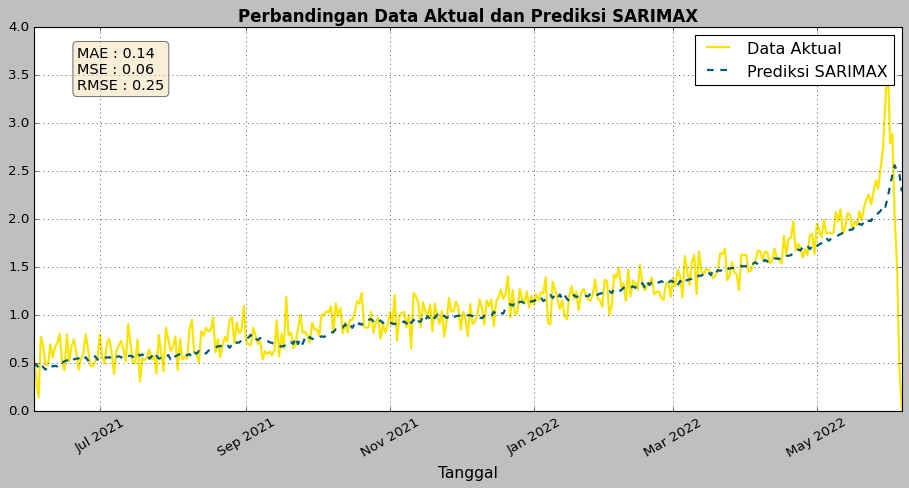

In [143]:
plt.figure(figsize=(14, 6))

# Plot data aktual
plt.plot(pred_df.index, pred_df['actual'], label='Data Aktual', color='#F9E400', linewidth=2)

# Plot prediksi SARIMAX
plt.plot(pred_df.index, pred_df['pred_SARIMAX'], label='Prediksi SARIMAX', color='#005C78', linestyle='--', linewidth=2)

# Menambahkan Metrik Evaluasi pada Plot
metrics_text = (
    f'MAE : {mae:.2f}\n'
    f'MSE : {mse:.2f}\n'
    f'RMSE : {rmse:.2f}'
)
plt.text(
    0.05, 0.95, metrics_text,
    transform=plt.gca().transAxes,
    fontsize=13,
    verticalalignment='top',
    bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5)
)

# Tambahkan judul dan label
plt.title('Perbandingan Data Aktual dan Prediksi SARIMAX', fontsize=15, fontweight='bold')
plt.xlabel('Tanggal', fontsize=14)
plt.xticks(rotation=30, fontsize=12)
plt.legend()

# Tampilkan plot
plt.grid(True)
plt.show()

###**Prediksi**

In [144]:
# Tentukan rentang tanggal untuk prediksi

start_date = '2022-06-07'
end_date = '2024-12-31'
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [145]:
# Buat prediksi untuk periode di masa depan

forecast = best_model_fit.get_forecast(steps=len(future_dates))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


In [146]:
# Buat DataFrame untuk prediksi

pred_df = pd.DataFrame({
    'date': future_dates,
    'predicted_mean': predicted_mean
})
pred_df.set_index('date', inplace=True)

In [147]:
pred_df

,predicted_mean
date,
2022-06-07,0.517531
2022-06-08,0.501977
2022-06-09,0.524913
2022-06-10,0.499116
2022-06-11,0.501250
...,...
2024-12-27,0.817285
2024-12-28,0.817842
2024-12-29,0.818425


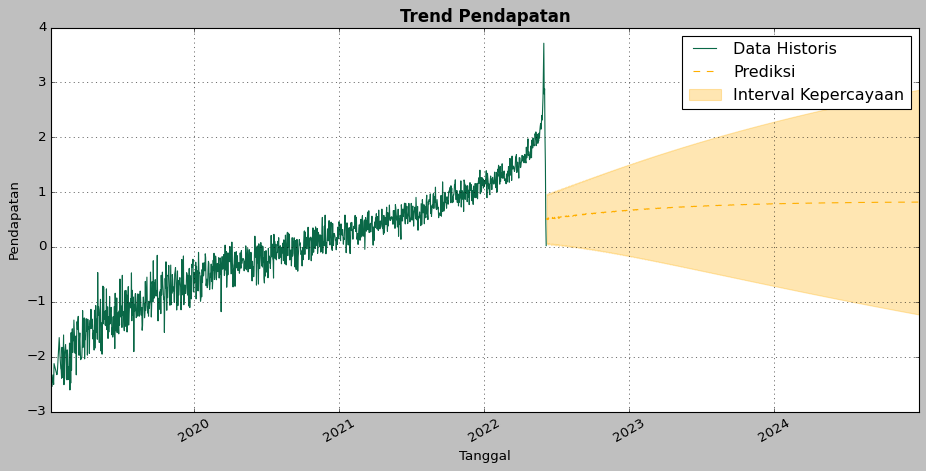

In [156]:
# Visualisasi hasil
plt.figure(figsize=(14, 6))

# Plot data historis
plt.plot(target.index, target, label='Data Historis', color='#0A6847')

# Plot prediksi
plt.plot(pred_df.index, pred_df['predicted_mean'], label='Prediksi', color='#FFAF00', linestyle='--')

# Plot interval kepercayaan
plt.fill_between(pred_df.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='#FFAF00', alpha=0.3, label='Interval Kepercayaan')

# Tambahkan judul dan label
plt.title('Trend Pendapatan', fontsize=15, fontweight='bold')
plt.xlabel('Tanggal')
plt.xticks(rotation=30, fontsize=12)
plt.ylabel('Pendapatan')
plt.legend()
plt.grid(True)
plt.show()

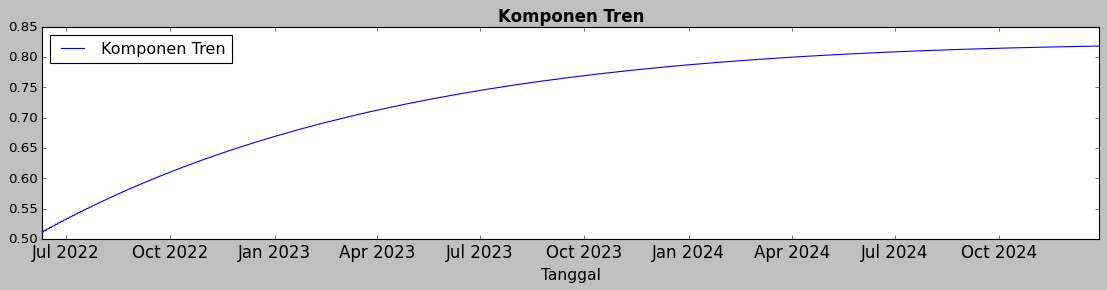

In [160]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Dekomposisi musiman pada data historis
decomposition = seasonal_decompose(pred_df['predicted_mean'], model='additive', period=s)

# Visualisasi komponen
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Komponen Tren', color='blue')
plt.legend(loc='best')
plt.title('Komponen Tren', fontsize=15, fontweight='bold')

plt.xlabel('Tanggal', fontsize=14)
plt.tight_layout()
plt.show()

Dari visualisasi tersebut dapat terlihat bahwa proyeksi penjualan akan terus meningkat (trend positif).

In [82]:
# Tambahkan kolom hari dalam minggu
pred_df['day_of_week'] = pred_df.index.day_name()

# Agregasi total pendapatan per hari dalam minggu
weekly_sales = pred_df.groupby('day_of_week')['predicted_mean'].sum()

# Urutkan berdasarkan urutan hari dalam minggu
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = weekly_sales.reindex(ordered_days)

print(weekly_sales)

day_of_week
Monday       98.665369
Tuesday      98.835969
Wednesday    98.557411
Thursday     98.575230
Friday       97.820494
Saturday     98.208357
Sunday       98.659717
Name: predicted_mean, dtype: float64


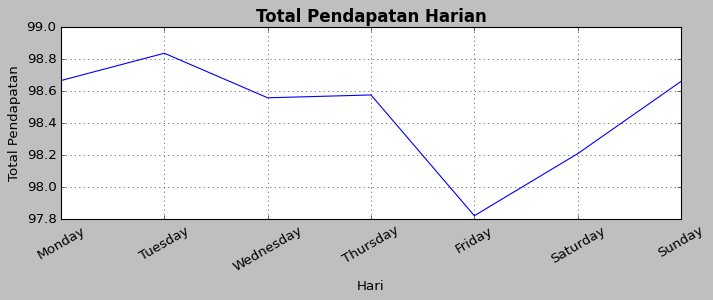

In [167]:
# Visualisasi total pendapatan per hari dalam minggu menggunakan plot garis
plt.figure(figsize=(10, 3))
plt.plot(weekly_sales.index, weekly_sales.values, linestyle='-', color='blue')

plt.title('Total Pendapatan Harian', fontsize=15, fontweight='bold')
plt.xlabel('Hari')
plt.xticks(rotation=30, fontsize=12)
plt.ylabel('Total Pendapatan')
plt.grid(True)
plt.show()

Hari terbaik penjualan terjadi pada hari selasa.

In [102]:
# Tambahkan kolom bulan
pred_df['month'] = pred_df.index.month_name()

# Cek apakah kolom 'month' sudah ada dalam DataFrame
print(pred_df.head())

# Agregasi total pendapatan per bulan tanpa memperhitungkan tahun
monthly_sales = pred_df.groupby('month')['predicted_mean'].sum().reset_index()

# Urutkan berdasarkan urutan bulan dalam tahun
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_sales['month'] = pd.Categorical(monthly_sales['month'], categories=ordered_months, ordered=True)

# Urutkan berdasarkan bulan
monthly_sales = monthly_sales.sort_values('month')

print(monthly_sales)

            predicted_mean day_of_week month  year
date                                              
2022-06-07        0.517531     Tuesday  June  2022
2022-06-08        0.501977   Wednesday  June  2022
2022-06-09        0.524913    Thursday  June  2022
2022-06-10        0.499116      Friday  June  2022
2022-06-11        0.501250    Saturday  June  2022
        month  predicted_mean
4     January       45.468927
3    February       42.399271
7       March       46.599937
0       April       45.585385
8         May       47.560431
6        June       58.914318
5        July       65.270563
1      August       66.474587
11  September       65.336125
10    October       68.482844
9    November       67.110592
2    December       70.119568


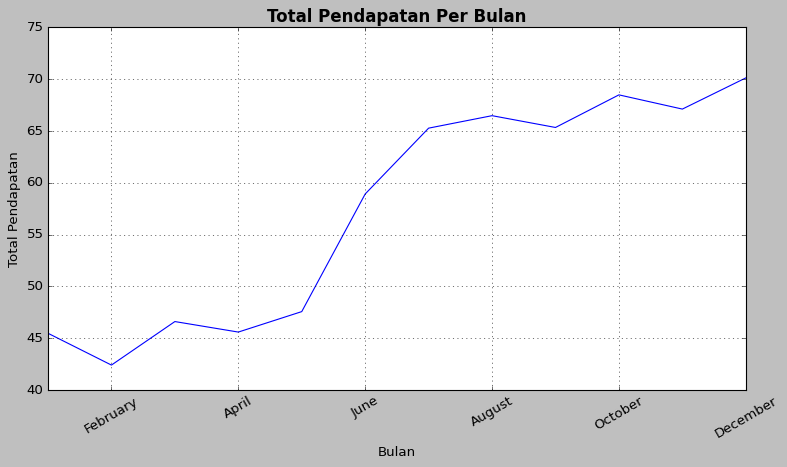

In [169]:
# Visualisasi total pendapatan per bulan menggunakan plot garis
plt.figure(figsize=(10, 6))

plt.plot(monthly_sales['month'], monthly_sales['predicted_mean'], linestyle='-', color='blue')

plt.title('Total Pendapatan Per Bulan', fontsize=15, fontweight='bold')
plt.xlabel('Bulan')
plt.ylabel('Total Pendapatan')

# Menampilkan setiap label ke-n (misalnya, setiap 2 bulan)
plt.xticks(ticks=range(1, len(monthly_sales['month']), 2), labels=monthly_sales['month'][1::2], rotation=30, fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

Lalu untuk bulan terbaik penjualan terjadi pada akhir tahun, yaitu Oktober-Desember.

In [170]:
pred_df.head()

,predicted_mean
date,
2022-06-07,0.517531
2022-06-08,0.501977
2022-06-09,0.524913
2022-06-10,0.499116
2022-06-11,0.501250


In [171]:
from google.colab import files

pred_df.to_csv('Forecasting by sale.csv', encoding = 'utf-8-sig')
files.download('Forecasting by sale.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##**Studi Kasus 2**

*   **Rekomendasi tempat / negara tujuan ekspansi pasar**

In [3]:
df_users.head()

,id,first_name,last_name,email,age,gender,state,street_address,postal_code,city,country,latitude,longitude,traffic_source,created_at
0,19279,Heidi,Jackson,heidijackson@example.org,50,F,Mie,894 Nicholas Curve Suite 865,513-0836,Suzuka City,Japan,34.851814,136.508713,Search,2020-11-07 12:40:00+00:00
1,5678,Michael,Brooks,michaelbrooks@example.org,58,M,Acre,0549 Deanna Land,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Email,2019-07-28 04:20:00+00:00
2,29694,Scott,Anderson,scottanderson@example.org,60,M,Acre,8979 Stephens Oval Apt. 816,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Facebook,2019-08-16 17:06:00+00:00
3,29967,Mike,Beck,mikebeck@example.org,12,M,Acre,76404 Michael Way Apt. 377,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2019-05-09 12:08:00+00:00
4,47096,Holly,Kennedy,hollykennedy@example.org,68,F,Acre,23658 Santana Mission,69917-400,Rio Branco,Brasil,-9.945568,-67.835610,Search,2019-05-24 15:53:00+00:00


In [4]:
df_orders.head()

,order_id,user_id,status,gender,created_at,returned_at,shipped_at,delivered_at,num_of_item
0,11,9,Shipped,F,2021-12-11 05:34:00+00:00,NaN,2021-12-12 10:01:00+00:00,NaN,3
1,12,9,Shipped,F,2022-01-18 05:34:00+00:00,NaN,2022-01-19 20:20:00+00:00,NaN,1
2,22,14,Shipped,F,2020-08-18 11:51:00+00:00,NaN,2020-08-20 16:45:00+00:00,NaN,1
3,25,16,Shipped,F,2020-12-16 08:35:00+00:00,NaN,2020-12-17 21:43:00+00:00,NaN,2
4,26,16,Shipped,F,2020-09-07 08:35:00+00:00,NaN,2020-09-10 00:15:00+00:00,NaN,1


In [5]:
df_users.columns

Index(['id', 'first_name', 'last_name', 'email', 'age', 'gender', 'state',
       'street_address', 'postal_code', 'city', 'country', 'latitude',
       'longitude', 'traffic_source', 'created_at'],
      dtype='object')

In [6]:
df_orders.columns

Index(['order_id', 'user_id', 'status', 'gender', 'created_at', 'returned_at',
       'shipped_at', 'delivered_at', 'num_of_item'],
      dtype='object')

In [7]:
# Join df_users dan df_orders berdasarkan kolom 'id' dan 'user_id'

df = pd.merge(df_users, df_orders, left_on='id', right_on='user_id', how='outer')

df.head()

,id,first_name,last_name,email,age,gender_x,state,street_address,postal_code,city,...,created_at_x,order_id,user_id,status,gender_y,created_at_y,returned_at,shipped_at,delivered_at,num_of_item
0,19279,Heidi,Jackson,heidijackson@example.org,50,F,Mie,894 Nicholas Curve Suite 865,513-0836,Suzuka City,...,2020-11-07 12:40:00+00:00,23800.0,19279.0,Shipped,F,2022-05-06 12:40:00+00:00,NaN,2022-05-08 03:13:00+00:00,NaN,2.0
1,5678,Michael,Brooks,michaelbrooks@example.org,58,M,Acre,0549 Deanna Land,69917-400,Rio Branco,...,2019-07-28 04:20:00+00:00,6905.0,5678.0,Shipped,M,2019-11-26 04:20:00+00:00,NaN,2019-11-27 15:32:00+00:00,NaN,1.0
2,29694,Scott,Anderson,scottanderson@example.org,60,M,Acre,8979 Stephens Oval Apt. 816,69917-400,Rio Branco,...,2019-08-16 17:06:00+00:00,36772.0,29694.0,Shipped,M,2021-09-15 17:06:00+00:00,NaN,2021-09-17 04:28:00+00:00,NaN,1.0
3,29694,Scott,Anderson,scottanderson@example.org,60,M,Acre,8979 Stephens Oval Apt. 816,69917-400,Rio Branco,...,2019-08-16 17:06:00+00:00,36773.0,29694.0,Complete,M,2020-03-29 17:06:00+00:00,NaN,2020-04-01 09:15:00+00:00,2020-04-04 03:41:00+00:00,1.0
4,29694,Scott,Anderson,scottanderson@example.org,60,M,Acre,8979 Stephens Oval Apt. 816,69917-400,Rio Branco,...,2019-08-16 17:06:00+00:00,36774.0,29694.0,Cancelled,M,2022-02-26 17:06:00+00:00,NaN,NaN,NaN,1.0


In [8]:
df.columns

Index(['id', 'first_name', 'last_name', 'email', 'age', 'gender_x', 'state',
       'street_address', 'postal_code', 'city', 'country', 'latitude',
       'longitude', 'traffic_source', 'created_at_x', 'order_id', 'user_id',
       'status', 'gender_y', 'created_at_y', 'returned_at', 'shipped_at',
       'delivered_at', 'num_of_item'],
      dtype='object')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144526 entries, 0 to 144525
Data columns (total 24 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   id              144526 non-null  int64  
 1   first_name      144526 non-null  object 
 2   last_name       144526 non-null  object 
 3   email           144526 non-null  object 
 4   age             144526 non-null  int64  
 5   gender_x        144526 non-null  object 
 6   state           144526 non-null  object 
 7   street_address  144526 non-null  object 
 8   postal_code     144526 non-null  object 
 9   city            143127 non-null  object 
 10  country         144526 non-null  object 
 11  latitude        144526 non-null  float64
 12  longitude       144526 non-null  float64
 13  traffic_source  144526 non-null  object 
 14  created_at_x    144526 non-null  object 
 15  order_id        124512 non-null  float64
 16  user_id         124512 non-null  float64
 17  status    

###**Exploratory Data Analysis**

In [10]:
# Memanggil kolom tertentu untuk analisis lanjutan
# Mengganti nama kolom

filtered_df = df[['age','gender_x','country', 'latitude', 'longitude','traffic_source','created_at_x','status',
                  'num_of_item']].rename(columns={'gender_x':'gender','created_at_x':'created_at'})

filtered_df.head()

,age,gender,country,latitude,longitude,traffic_source,created_at,status,num_of_item
0,50,F,Japan,34.851814,136.508713,Search,2020-11-07 12:40:00+00:00,Shipped,2.0
1,58,M,Brasil,-9.945568,-67.835610,Email,2019-07-28 04:20:00+00:00,Shipped,1.0
2,60,M,Brasil,-9.945568,-67.835610,Facebook,2019-08-16 17:06:00+00:00,Shipped,1.0
3,60,M,Brasil,-9.945568,-67.835610,Facebook,2019-08-16 17:06:00+00:00,Complete,1.0
4,60,M,Brasil,-9.945568,-67.835610,Facebook,2019-08-16 17:06:00+00:00,Cancelled,1.0


In [11]:
filtered_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144526 entries, 0 to 144525
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   age             144526 non-null  int64  
 1   gender          144526 non-null  object 
 2   country         144526 non-null  object 
 3   latitude        144526 non-null  float64
 4   longitude       144526 non-null  float64
 5   traffic_source  144526 non-null  object 
 6   created_at      144526 non-null  object 
 7   status          124512 non-null  object 
 8   num_of_item     124512 non-null  float64
dtypes: float64(3), int64(1), object(5)
memory usage: 9.9+ MB


In [12]:
# Mengecek apakah ada baris duplikat
duplicate_rows = filtered_df[filtered_df.duplicated()]

# Menampilkan jumlah baris duplikat
num_duplicates = duplicate_rows.shape[0]
print(f"Jumlah baris duplikat: {num_duplicates}")

# Menampilkan baris duplikat
duplicate_rows

Jumlah baris duplikat: 7332


,age,gender,country,latitude,longitude,traffic_source,created_at,status,num_of_item
21,22,F,Brasil,-9.857324,-69.437057,Facebook,2019-01-23 06:06:00+00:00,Processing,1.0
33,58,M,Brasil,-8.325245,-71.553030,Search,2020-02-14 08:41:00+00:00,Complete,1.0
41,22,M,Brasil,-8.065346,-72.870949,Search,2021-10-09 14:06:00+00:00,Shipped,2.0
50,47,M,Brasil,-8.065346,-72.870949,Search,2019-02-16 03:41:00+00:00,Processing,1.0
59,15,M,Brasil,-8.065346,-72.870949,Search,2020-08-24 00:05:00+00:00,Shipped,1.0
...,...,...,...,...,...,...,...,...,...
144478,21,F,China,37.111529,79.902473,Search,2020-03-23 12:29:00+00:00,Shipped,1.0
144479,21,F,China,37.111529,79.902473,Search,2020-03-23 12:29:00+00:00,Shipped,1.0
144482,12,M,China,37.111529,79.902473,Search,2019-08-20 05:15:00+00:00,Shipped,1.0
144495,31,F,South Korea,33.391753,126.266267,Display,2019-01-20 16:40:00+00:00,Complete,1.0


In [13]:
# Menghapus baris duplikat
df_cleaned = filtered_df.drop_duplicates()

# Menampilkan jumlah baris setelah pembersihan duplikat
print(f"Jumlah baris setelah pembersihan duplikat: {df_cleaned.shape[0]}")

Jumlah baris setelah pembersihan duplikat: 137194


In [14]:
# Mengecek jumlah nilai hilang di setiap kolom

missing_values = df_cleaned.isnull().sum()
print(missing_values)

age                   0
gender                0
country               0
latitude              0
longitude             0
traffic_source        0
created_at            0
status            20014
num_of_item       20014
dtype: int64


In [15]:
# Menghapus baris yang memiliki nilai hilang di kolom tertentu
df_cleaned = df_cleaned.dropna()

# Mengecek kembali nilai hilang setelah pembersihan
missing_values_after = df_cleaned.isnull().sum()

# Menampilkan jumlah baris setelah pembersihan missing values
print(missing_values_after)
print(f"Jumlah baris setelah pembersihan missing values: {df_cleaned.shape[0]}")

age               0
gender            0
country           0
latitude          0
longitude         0
traffic_source    0
created_at        0
status            0
num_of_item       0
dtype: int64
Jumlah baris setelah pembersihan missing values: 117180


In [16]:
df_cleaned.dtypes

age                 int64
gender             object
country            object
latitude          float64
longitude         float64
traffic_source     object
created_at         object
status             object
num_of_item       float64
dtype: object

In [17]:
# Mengubah tipe data 'created_at' menjadi datetime dengan format yang sesuai

df_cleaned['created_at'] = pd.to_datetime(df_cleaned['created_at'], format='ISO8601')

df_cleaned.dtypes

age                             int64
gender                         object
country                        object
latitude                      float64
longitude                     float64
traffic_source                 object
created_at        datetime64[ns, UTC]
status                         object
num_of_item                   float64
dtype: object

In [18]:
# remove timezone dari datetime

df_cleaned['created_at']=df_cleaned['created_at'].dt.tz_localize(None)

In [19]:
# mengurutkan data sesuai waktu terjadinya transaksi

df_cleaned = df_cleaned.sort_values(by='created_at')

df_cleaned

,age,gender,country,latitude,longitude,traffic_source,created_at,status,num_of_item
140440,68,M,France,47.081671,5.476258,Search,2019-01-02 00:07:00.000000,Cancelled,2.0
108343,25,M,Brasil,-23.046432,-46.979018,Search,2019-01-02 00:08:00.000000,Returned,1.0
49022,19,M,China,25.108812,104.936952,Search,2019-01-02 00:18:00.000000,Complete,2.0
81611,48,M,China,28.765338,121.485589,Search,2019-01-02 00:22:00.000000,Shipped,1.0
8320,65,F,China,39.492384,115.866816,Search,2019-01-02 00:46:00.000000,Processing,2.0
...,...,...,...,...,...,...,...,...,...
54477,57,F,Brasil,-25.125467,-51.104159,Email,2022-06-01 19:13:43.280184,Complete,1.0
58407,39,F,China,29.595281,103.501284,Search,2022-06-01 19:17:46.138553,Shipped,1.0
58408,39,F,China,29.595281,103.501284,Search,2022-06-01 19:17:46.138553,Complete,1.0
58409,39,F,China,29.595281,103.501284,Search,2022-06-01 19:17:46.138553,Returned,1.0


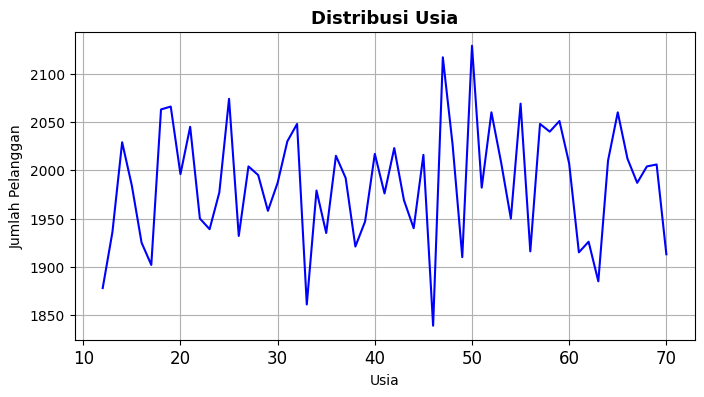

In [20]:
# Hitung jumlah pelanggan per usia
age_counts = df_cleaned['age'].value_counts().sort_index()

# Histogram Usia
plt.figure(figsize=(8,4))
sns.lineplot(x=age_counts.index, y=age_counts.values, color='blue')
plt.title('Distribusi Usia', fontsize=13, fontweight='bold')
plt.xlabel('Usia')
plt.xticks(fontsize=12)
plt.ylabel('Jumlah Pelanggan')
plt.grid(True)
plt.show()

In [21]:
# Hitung jumlah masing-masing gender

df_cleaned['gender'].value_counts().to_frame()

,count
gender,
F,58611
M,58569


Text(0.5, 1.02, 'Distribusi Gender')

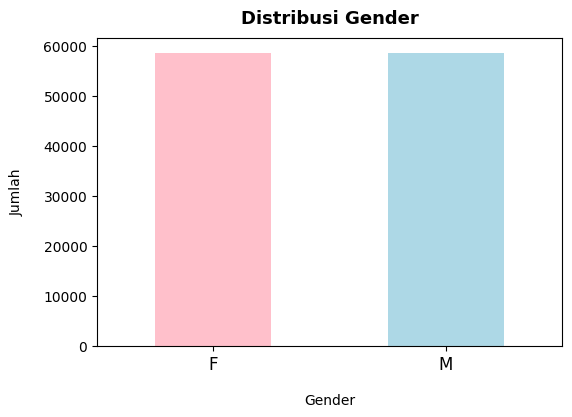

In [22]:
# Melihat distribusi kelas (visualisasi dgn diagram batang dgn library seaborn)

df_cleaned['gender'].value_counts().plot(kind='bar', figsize=(6, 4), rot=0, color = ['pink', 'lightblue'])
plt.xlabel('Gender', labelpad=14)
plt.xticks(fontsize=12)
plt.ylabel('Jumlah', labelpad=14)
plt.title('Distribusi Gender', y=1.02, fontsize=13, fontweight='bold')

In [23]:
# Hitung jumlah masing-masing negara

country_counts = df_cleaned['country'].value_counts().to_frame()
country_counts.reset_index(inplace=True)
country_counts.columns = ['Country', 'Count']
country_counts

,Country,Count
0,China,39933
1,United States,25879
2,Brasil,17229
3,South Korea,6192
4,France,5510
5,United Kingdom,5394
6,Germany,5069
7,Spain,4855
8,Japan,2783
9,Australia,2629


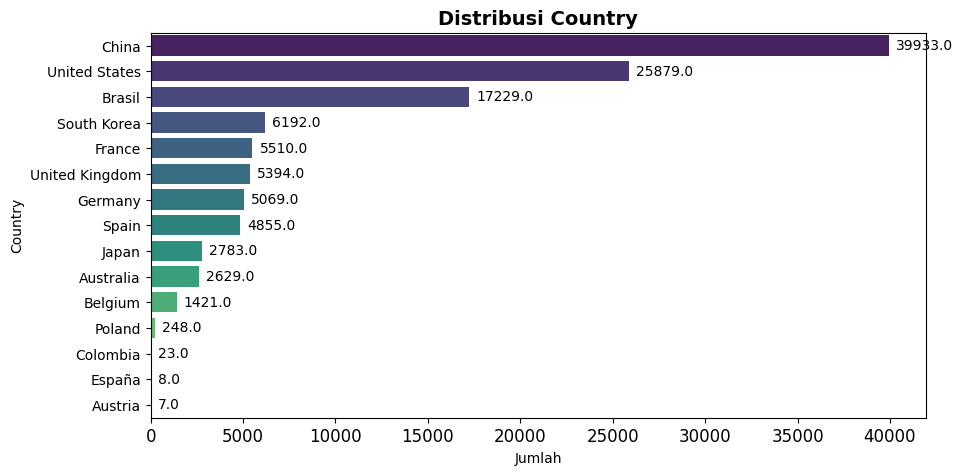

In [24]:
plt.figure(figsize=(10, 5))
ax = sns.barplot(x='Count', y='Country', data=country_counts, palette='viridis')

# Menambahkan label jumlah pada setiap bar
for p in ax.patches:
    ax.annotate(f'{p.get_width()}',
                (p.get_width(), p.get_y() + p.get_height() / 2.),
                ha='left', va='center',
                xytext=(5, 0), textcoords='offset points')

plt.title('Distribusi Country', fontsize=14, fontweight='bold')
plt.xlabel('Jumlah')
plt.xticks(fontsize=12)
plt.ylabel('Country')
plt.show()

In [25]:
# Hitung jumlah masing-masing traffic_source

traffic_source_counts = df_cleaned['traffic_source'].value_counts().to_frame()
traffic_source_counts.reset_index(inplace=True)
traffic_source_counts.columns = ['traffic_source', 'Count']
traffic_source_counts

,traffic_source,Count
0,Search,82119
1,Organic,17468
2,Facebook,7230
3,Email,5691
4,Display,4672


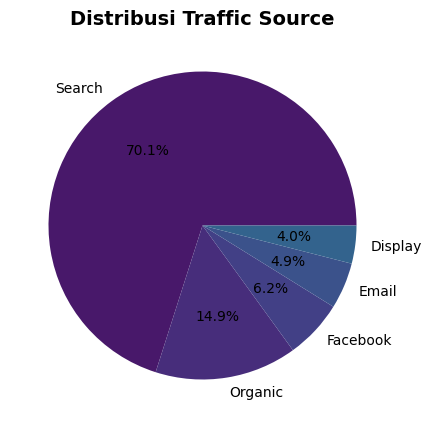

In [26]:
plt.figure(figsize=(5,5))
plt.pie(traffic_source_counts['Count'], labels=traffic_source_counts['traffic_source'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(country_counts)))
plt.title('Distribusi Traffic Source', fontsize=14, fontweight='bold')
plt.show()

In [27]:
# Hitung jumlah masing-masing status

status_counts = df_cleaned['status'].value_counts().to_frame()
status_counts.reset_index(inplace=True)
status_counts.columns = ['status', 'Count']
status_counts

,status,Count
0,Shipped,34571
1,Complete,29272
2,Processing,23739
3,Cancelled,17759
4,Returned,11839


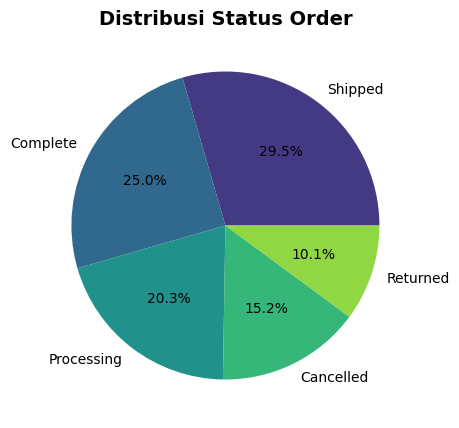

In [28]:
plt.figure(figsize=(5,5))
plt.pie(status_counts['Count'], labels=status_counts['status'], autopct='%1.1f%%', colors=sns.color_palette('viridis', len(status_counts)))
plt.title('Distribusi Status Order', fontsize=14, fontweight='bold')
plt.show()

**Rekomendasi Tempat**
*   Untuk merekomendasikan tempat diperlukan informasi yang berisi jumlah order pada tiap negara beserta status ordernya. oleh karena itu diperlukan pengelompokan data sesuai dengan yang diminta.

In [29]:
# memanggil data

df_cleaned.head()

,age,gender,country,latitude,longitude,traffic_source,created_at,status,num_of_item
140440,68,M,France,47.081671,5.476258,Search,2019-01-02 00:07:00,Cancelled,2.0
108343,25,M,Brasil,-23.046432,-46.979018,Search,2019-01-02 00:08:00,Returned,1.0
49022,19,M,China,25.108812,104.936952,Search,2019-01-02 00:18:00,Complete,2.0
81611,48,M,China,28.765338,121.485589,Search,2019-01-02 00:22:00,Shipped,1.0
8320,65,F,China,39.492384,115.866816,Search,2019-01-02 00:46:00,Processing,2.0


In [30]:
# pengelompokan jumlah order tiap negara dan status order

grouped_data = df_cleaned.groupby(['country','status',])['num_of_item'].sum().unstack()

grouped_data

status,Cancelled,Complete,Processing,Returned,Shipped
country,,,,,
Australia,593.0,917.0,759.0,401.0,1174.0
Austria,NaN,1.0,NaN,NaN,7.0
Belgium,291.0,532.0,431.0,201.0,647.0
Brasil,3906.0,6337.0,5042.0,2569.0,7492.0
China,8777.0,14670.0,11947.0,5897.0,17449.0
Colombia,8.0,11.0,5.0,3.0,13.0
España,1.0,2.0,5.0,1.0,3.0
France,1181.0,2015.0,1617.0,760.0,2475.0
Germany,1134.0,1795.0,1468.0,796.0,2191.0


<Figure size 1200x600 with 0 Axes>

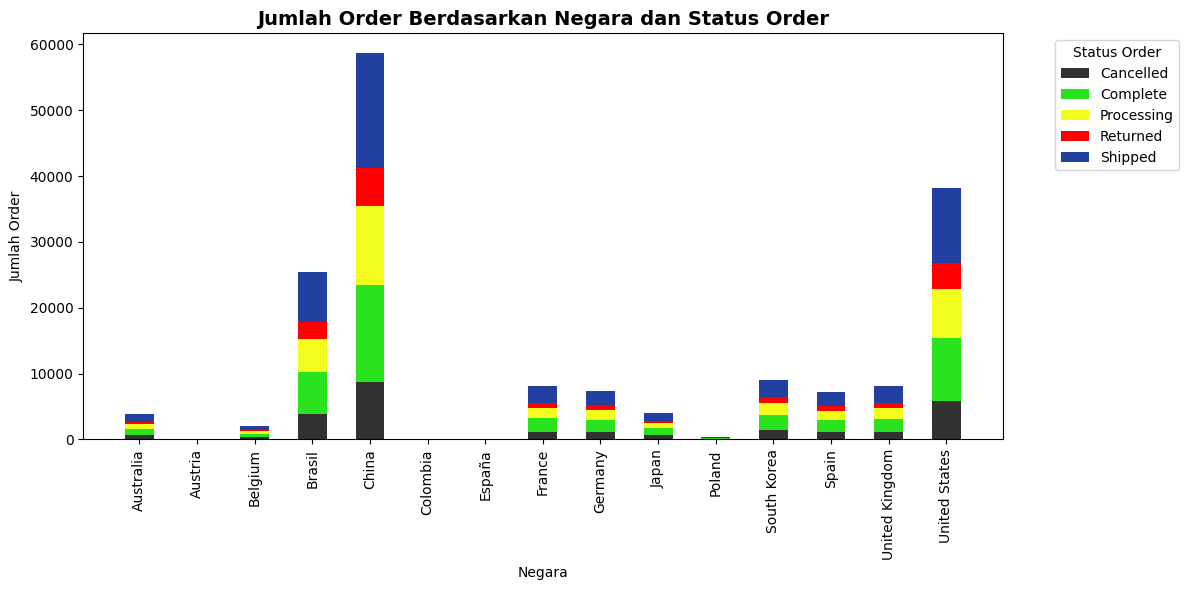

In [31]:
# Mengatur warna untuk setiap kategori order_status
# colors = ['#003f5c', '#58508d', '#bc5090', '#ff6361','#ffa600']
colors = ['#333232', '#29e31f', '#f2fd1e', '#ff0000','#21409f']

# Mengatur ukuran plot
plt.figure(figsize=(12, 6))

# Mengatur posisi bar dan lebar bar
bar_width = 0.5  # Mengatur lebar bar
index = np.arange(len(grouped_data))

# Membuat bar plot dengan warna kustom dan lebar yang disesuaikan
fig, ax = plt.subplots(figsize=(12, 6))
bottom = np.zeros(len(grouped_data))

for i, status in enumerate(grouped_data.columns):
    ax.bar(index, grouped_data[status], bar_width, bottom=bottom, label=status, color=colors[i])
    bottom += grouped_data[status]

# Mengatur label dan judul
ax.set_xlabel('Negara')
ax.set_ylabel('Jumlah Order')
ax.set_title('Jumlah Order Berdasarkan Negara dan Status Order', fontsize=14, fontweight='bold')
ax.set_xticks(index)
ax.set_xticklabels(grouped_data.index, rotation=90)

# Menyesuaikan posisi legenda
ax.legend(title='Status Order', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

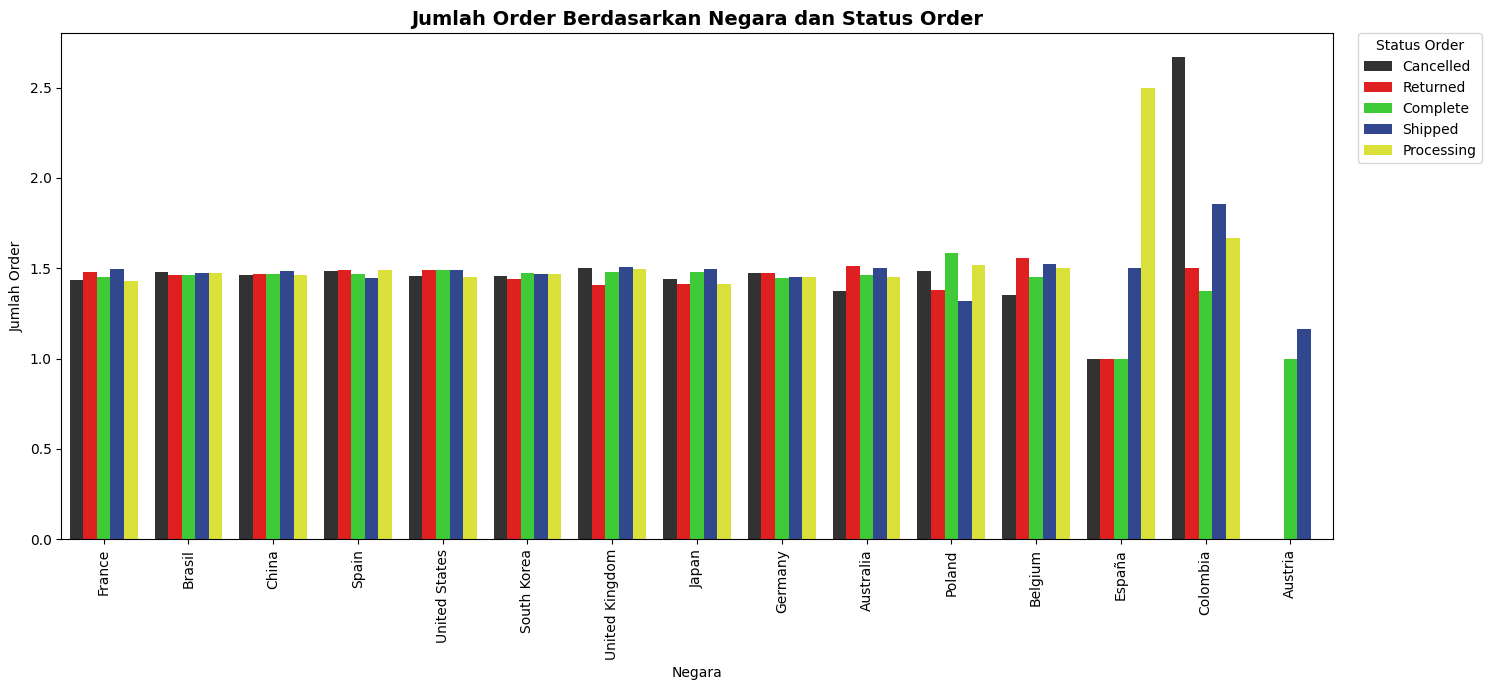

In [32]:
# Mengatur ukuran plot
plt.figure(figsize=(15,7))

# Membuat bar plot horizontal dengan seaborn tanpa garis tengah dan warna kustom
palette_colors = {
    'Complete': '#29e31f',
    'Shipped': '#21409f',
    'Processing': '#f2fd1e',
    'Cancelled': '#333232',
    'Returned': '#FF0000',
}

# Membuat bar plot dengan seaborn
sns.barplot(data=df_cleaned, x='country', y='num_of_item', hue='status', ci=None, palette=palette_colors)

plt.title('Jumlah Order Berdasarkan Negara dan Status Order', fontsize=14, fontweight='bold')
plt.xlabel('Negara')
plt.xticks(rotation=90)
plt.ylabel('Jumlah Order')
plt.legend(title='Status Order', bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()

plt.show()

In [33]:
# Pilih hanya data dengan status shipped dan complete untuk memastikan bahwa Anda hanya menggunakan transaksi final dalam model forecasting

map = df_cleaned[df_cleaned['status'].isin(['Complete', 'Shipped'])]
map.head()

,age,gender,country,latitude,longitude,traffic_source,created_at,status,num_of_item
49022,19,M,China,25.108812,104.936952,Search,2019-01-02 00:18:00,Complete,2.0
81611,48,M,China,28.765338,121.485589,Search,2019-01-02 00:22:00,Shipped,1.0
8318,65,F,China,39.492384,115.866816,Search,2019-01-02 00:46:00,Complete,1.0
135288,70,M,Spain,40.469963,-3.457841,Search,2019-01-02 01:15:00,Shipped,1.0
131198,41,M,Brasil,-29.386288,-50.899687,Search,2019-01-02 02:19:00,Shipped,1.0


In [34]:
# lihat distribusi kolom 'status'

map['status'].value_counts().to_frame()

,count
status,
Shipped,34571
Complete,29272


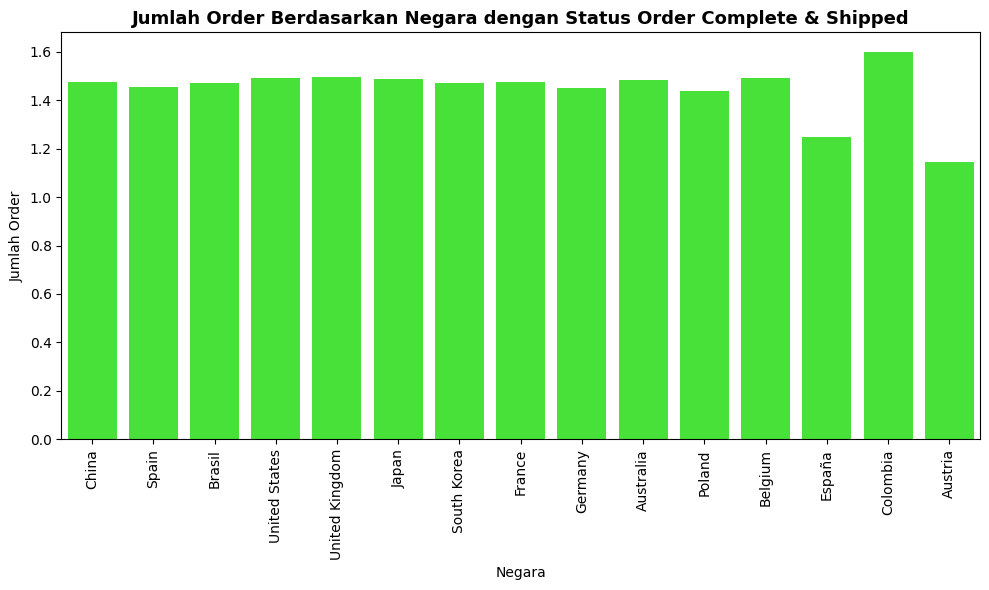

In [35]:
# Mengatur ukuran plot
plt.figure(figsize=(10,6))

# Membuat bar plot dengan seaborn
sns.barplot(data=map, x='country', y='num_of_item', ci=None, color='#30fd1e')

plt.title('Jumlah Order Berdasarkan Negara dengan Status Order Complete & Shipped', fontsize=13, fontweight='bold')
plt.xlabel('Negara')
plt.xticks(rotation=90)
plt.ylabel('Jumlah Order')
plt.tight_layout()

plt.show()

In [36]:
# Pilih hanya data dengan status cancelled dan returned untuk melihat distribusi negara yang harus dihindari

map2 = df_cleaned[df_cleaned['status'].isin(['Cancelled', 'Returned'])]
map2.head()

,age,gender,country,latitude,longitude,traffic_source,created_at,status,num_of_item
140440,68,M,France,47.081671,5.476258,Search,2019-01-02 00:07:00,Cancelled,2.0
108343,25,M,Brasil,-23.046432,-46.979018,Search,2019-01-02 00:08:00,Returned,1.0
29410,69,M,China,24.741471,118.638147,Search,2019-01-02 01:53:00,Returned,2.0
57493,57,M,China,30.684447,104.092908,Search,2019-01-02 01:57:00,Cancelled,1.0
131200,41,M,Brasil,-29.386288,-50.899687,Search,2019-01-02 02:19:00,Cancelled,1.0


In [37]:
# lihat distribusi kolom 'status'

map2['status'].value_counts().to_frame()

,count
status,
Cancelled,17759
Returned,11839


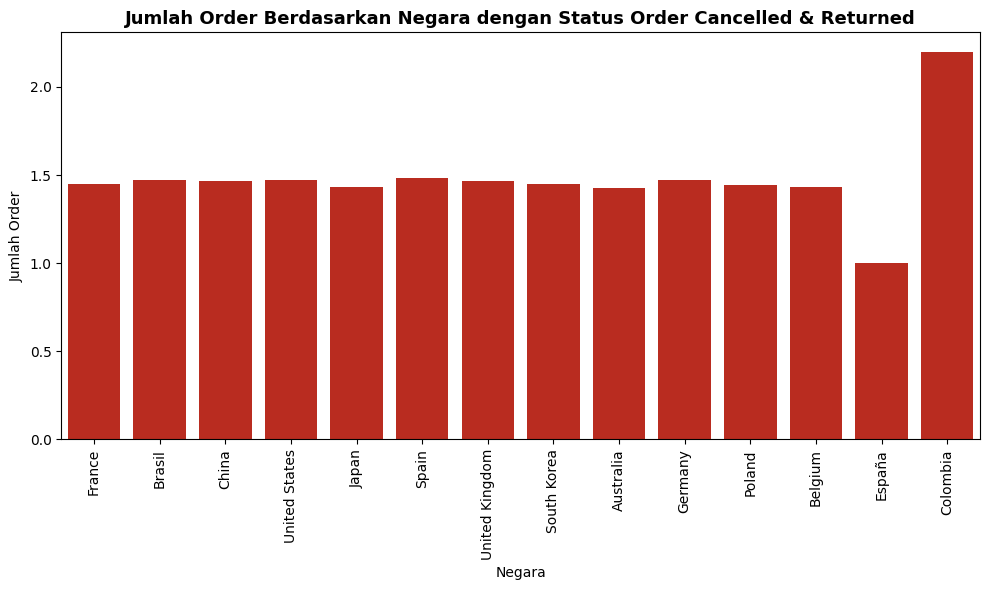

In [38]:
# Mengatur ukuran plot
plt.figure(figsize=(10,6))

# Membuat bar plot dengan seaborn
sns.barplot(data=map2, x='country', y='num_of_item', ci=None, color='#d21706')

plt.title('Jumlah Order Berdasarkan Negara dengan Status Order Cancelled & Returned', fontsize=13, fontweight='bold')
plt.xlabel('Negara')
plt.xticks(rotation=90)
plt.ylabel('Jumlah Order')
plt.tight_layout()

plt.show()

###**Forecasting berdasarkan jumlah order**

In [39]:
# hanya ingin menampilkan kolom yang ingin ditampilkan
# status order complete & Shipped

data = map[['created_at','num_of_item']]
data

,created_at,num_of_item
49022,2019-01-02 00:18:00.000000,2.0
81611,2019-01-02 00:22:00.000000,1.0
8318,2019-01-02 00:46:00.000000,1.0
135288,2019-01-02 01:15:00.000000,1.0
131198,2019-01-02 02:19:00.000000,1.0
...,...,...
44955,2022-06-01 19:07:46.024013,2.0
54477,2022-06-01 19:13:43.280184,1.0
58407,2022-06-01 19:17:46.138553,1.0
58408,2022-06-01 19:17:46.138553,1.0


In [40]:
# grouping data perhari

data_grouping = data.groupby(pd.Grouper(key='created_at', axis=0,freq='D')).sum()
data_grouping

,num_of_item
created_at,
2019-01-02,48.0
2019-01-03,86.0
2019-01-04,68.0
2019-01-05,62.0
2019-01-06,66.0
...,...
2022-05-28,449.0
2022-05-29,434.0
2022-05-30,483.0


In [41]:
# buang data yang memiliki nilai 0

data_grouping = data_grouping[~data_grouping['num_of_item'].isin ([0.0])]
data_grouping.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1247 entries, 2019-01-02 to 2022-06-01
Freq: D
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   num_of_item  1247 non-null   float64
dtypes: float64(1)
memory usage: 19.5 KB


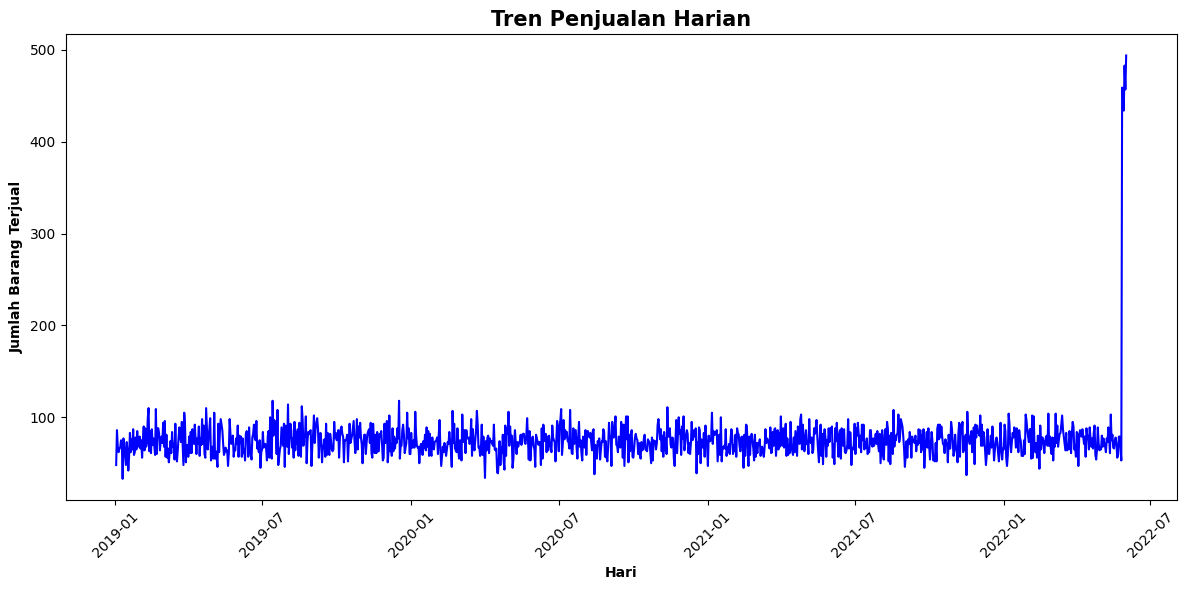

In [42]:
# Membuat plot tren penjualan
plt.figure(figsize=(12,6))
sns.lineplot(data=data_grouping, x='created_at', y='num_of_item', color='blue')

# Menambahkan judul dan label dengan tulisan bold dan diperbesar
plt.title('Tren Penjualan Harian', fontsize=15, fontweight='bold')
plt.xlabel('Hari', fontweight='bold')
plt.ylabel('Jumlah Barang Terjual', fontweight='bold')
plt.xticks(rotation=45)

# Menampilkan plot
plt.tight_layout()
plt.show()

In [43]:
data_grouping.describe()

,num_of_item
count,1247.000000
mean,75.648757
std,30.239867
min,33.000000
25%,64.000000
50%,74.000000
75%,83.000000
max,494.000000


###**Transformasi Data**

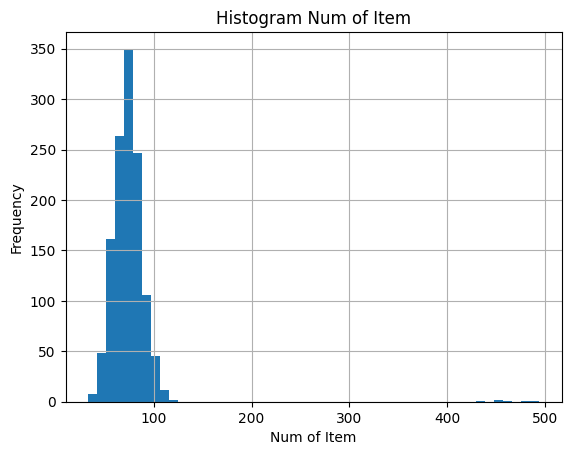

In [44]:
# Visualisasi histogram

data_grouping['num_of_item'].hist(bins=50)
plt.title('Histogram Num of Item')
plt.xlabel('Num of Item')
plt.ylabel('Frequency')
plt.show()

In [45]:
from scipy.stats import skew

# Hitung skewness
skewness = skew(data_grouping['num_of_item'].dropna())
print(f'Skewness: {skewness}')

Skewness: 10.15643238821734


*   Skewness sebesar 10.16 menunjukkan bahwa data Anda memiliki skewness positif yang cukup tinggi, artinya data cenderung condong ke arah nilai yang lebih rendah dengan beberapa nilai ekstrem yang lebih tinggi.
*   Transformasi log dan BoxCox sering digunakan untuk data yang skewed positif. Cari yang paling mendekati 0



In [46]:
# Transformasi Log

data_grouping['num_of_item_log'] = np.log(data_grouping['num_of_item'] + 1)  # Menambahkan 1 untuk menghindari log(0)

In [47]:
from scipy import stats

# Transformasi BoxCox
data_grouping['num_of_item_boxcox'], _ = stats.boxcox(data_grouping['num_of_item'] + 1)  # Tambahkan 1 untuk menghindari log(0)

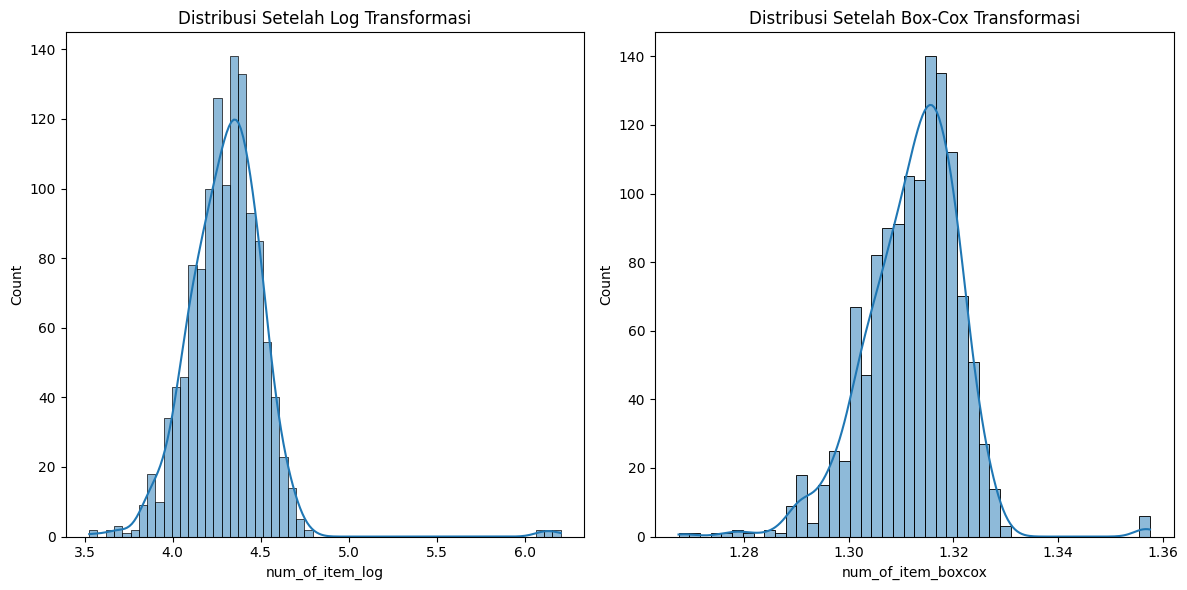

In [48]:
plt.figure(figsize=(12, 6))

# Distribusi setelah Log Transformasi
plt.subplot(1, 2, 1)
sns.histplot(data_grouping['num_of_item_log'], kde=True)
plt.title('Distribusi Setelah Log Transformasi')

# Distribusi setelah Box-Cox Transformasi
plt.subplot(1, 2, 2)
sns.histplot(data_grouping['num_of_item_boxcox'], kde=True)
plt.title('Distribusi Setelah Box-Cox Transformasi')

plt.tight_layout()
plt.show()

In [49]:
# Hitung skewness setelah Log Transformasi dan BoxCox Transformasi

skewness_log = skew(data_grouping['num_of_item_log'].dropna())
skewness_boxcox = skew(data_grouping['num_of_item_boxcox'].dropna())

print(f'Skewness setelah Log Transformasi: {skewness_log}')
print(f'Skewness setelah BoxCox Transformasi: {skewness_boxcox}')

Skewness setelah Log Transformasi: 2.2089614388634407
Skewness setelah BoxCox Transformasi: -0.2257191100118295


Box-Cox menghasilkan skewness mendekati 0 dan data terlihat lebih normal setelah transformasi, maka Box-Cox adalah pilihan yang lebih baik dibandingkan log transformasi.

In [50]:
data_grouping.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1247 entries, 2019-01-02 to 2022-06-01
Freq: D
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   num_of_item         1247 non-null   float64
 1   num_of_item_log     1247 non-null   float64
 2   num_of_item_boxcox  1247 non-null   float64
dtypes: float64(3)
memory usage: 39.0 KB


In [51]:
data_grouping.head(2)

,num_of_item,num_of_item_log,num_of_item_boxcox
created_at,,,
2019-01-02,48.0,3.891820,1.291994
2019-01-03,86.0,4.465908,1.319529


In [52]:
# Memanggil kolom tertentu untuk analisis model
# Mengganti nama kolom

data_filtered = data_grouping[['num_of_item_boxcox']].rename(columns={'num_of_item_boxcox':'num_of_item'})

data_filtered.head(2)

,num_of_item
created_at,
2019-01-02,1.291994
2019-01-03,1.319529


### **Cek Stationaritas Data**

In [56]:
# Ho: It is non stationary
# H1: It is stationary

from statsmodels.tsa.stattools import adfuller

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

In [57]:
target = data_filtered['num_of_item']

In [58]:
adfuller_test(target)

ADF Test Statistic : -21.390255321169008
p-value : 0.0
#Lags Used : 1
Number of Observations Used : 1245
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [59]:
# adfuller_test(target.diff()[1:])

In [60]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from typing import Union

def optimize_SARIMAX(endog: Union[pd.Series, list], exog: None, order_list: list, d: int, D: int, s: int) -> pd.DataFrame:

    results = []

    for order in tqdm_notebook(order_list):
        try:
            model = SARIMAX(
                endog,
                exog,
                order=(order[0], d, order[1]),
                seasonal_order=(order[2], D, order[3], s),
                simple_differencing=False).fit(disp=False)
        except:
            continue

        aic = model.aic
        results.append([order, aic])

    result_df = pd.DataFrame(results)
    result_df.columns = ['(p,q,P,Q)', 'AIC']

    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)

    return result_df

###**Pemodelan**

In [61]:
# Hitung jumlah data untuk data pelatihan (70%) dan data pengujian (30%)
train_size = int(len(target) * 0.7)
test_size = len(target) - train_size

# Bagi data menjadi data pelatihan dan data pengujian
target_train = target[:train_size]
target_test = target[train_size:]

# Cetak panjang masing-masing data
print("Jumlah data pelatihan:", len(target_train))
print("Jumlah data pengujian:", len(target_test))

Jumlah data pelatihan: 872
Jumlah data pengujian: 375


In [62]:
from itertools import product

p = range(0, 4, 1)
d = 0
q = range(0, 4, 1)
P = range(0, 4, 1)
D = 0
Q = range(0, 4, 1)
s = 7

parameters = product(p, q, P, Q)
parameters_list = list(parameters)

In [66]:
from tqdm import tqdm_notebook

# result_df = optimize_SARIMAX(endog=target_train, exog=exog_train, order_list=parameters_list, d=d, D=D, s=s)
result_df = optimize_SARIMAX(endog=target_train, exog=None, order_list=parameters_list, d=d, D=D, s=s)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,"(p,q,P,Q)",AIC
0,"(1, 1, 0, 0)",-5755.641635
1,"(2, 3, 0, 0)",-5751.888063
2,"(2, 2, 0, 0)",-5742.788808
3,"(2, 2, 0, 1)",-5742.594952
4,"(2, 2, 0, 2)",-5740.991354
...,...,...
251,"(0, 0, 0, 2)",705.661358
252,"(0, 1, 0, 1)",742.161954
253,"(0, 1, 0, 0)",1761.797669
254,"(0, 0, 0, 1)",1785.985516


In [67]:
# variabel

p = 1
d = 0
q = 1
P = 0
D = 0
Q = 0
s = 7

In [68]:
best_model = SARIMAX(endog=target_train, exog=None, order=(p,d,q), seasonal_order=(P,D,Q,s), simple_differencing=False)
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:            num_of_item   No. Observations:                  872
Model:               SARIMAX(1, 0, 1)   Log Likelihood                2880.821
Date:                Sat, 27 Jul 2024   AIC                          -5755.642
Time:                        12:50:18   BIC                          -5741.329
Sample:                    01-02-2019   HQIC                         -5750.166
                         - 05-22-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.0000   2.25e-08   4.45e+07      0.000       1.000       1.000
ma.L1         -0.9900      0.006   -158.759      0.000      -1.002      -0.978
sigma2      7.783e-05   2.96e-06     26.290      0.0

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [69]:
def recursive_forecast(Endog: Union[pd.Series, list], train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = Endog[:i].iloc[-1]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'SARIMAX':
        pred_SARIMAX = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(endog=Endog[:i], exog=None, order=(p,d,q), seasonal_order=(P,D,Q,s), simple_differencing=False, enforce_stationarity=False)
            res = model.fit(disp=False)
            predictions = res.get_prediction(exog=exog)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_SARIMAX.extend(oos_pred)

        return pred_SARIMAX

In [70]:
# Hitung jumlah data untuk data pelatihan (70%) dan data pengujian (30%)
train_size = int(len(target) * 0.7)
test_size = len(target) - train_size

# Bagi data menjadi data pelatihan dan data pengujian
target_train = target[:train_size]
target_test = target[train_size:]

pred_df = pd.DataFrame({'actual': target_test})

TRAIN_LEN = len(target_train)
HORIZON = len(target_test)
WINDOW = 1

exog=None

pred_last_value = recursive_forecast(Endog=target, train_len=TRAIN_LEN, horizon=HORIZON, window=WINDOW, method='last')
pred_SARIMAX = recursive_forecast(Endog=target, train_len=TRAIN_LEN, horizon=HORIZON, window=WINDOW, method='SARIMAX')

pred_df['pred_last_value'] = pred_last_value
pred_df['pred_SARIMAX'] = pred_SARIMAX

pred_df

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood op

,actual,pred_last_value,pred_SARIMAX
created_at,,,
2021-05-23,1.293171,1.317679,1.312345
2021-05-24,1.316188,1.293171,1.312559
2021-05-25,1.319969,1.316188,1.307091
2021-05-26,1.315669,1.319969,1.309660
2021-05-27,1.301307,1.315669,1.312550
...,...,...,...
2022-05-28,1.356538,1.356792,1.312257
2022-05-29,1.356137,1.356538,1.322124
2022-05-30,1.357365,1.356137,1.313345


###**Evaluasi**

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Hitung MAE, MSE, RMSE, dan MAPE
mae = mean_absolute_error(pred_df['actual'], pred_df['pred_SARIMAX'])
mse = mean_squared_error(pred_df['actual'], pred_df['pred_SARIMAX'])
rmse = np.sqrt(mse)

print(f'MAE: {mae:.2f}')
print(f'MSE: {mse:.2f}')
print(f'RMSE: {rmse:.2f}')

MAE: 0.01
MSE: 0.00
RMSE: 0.01


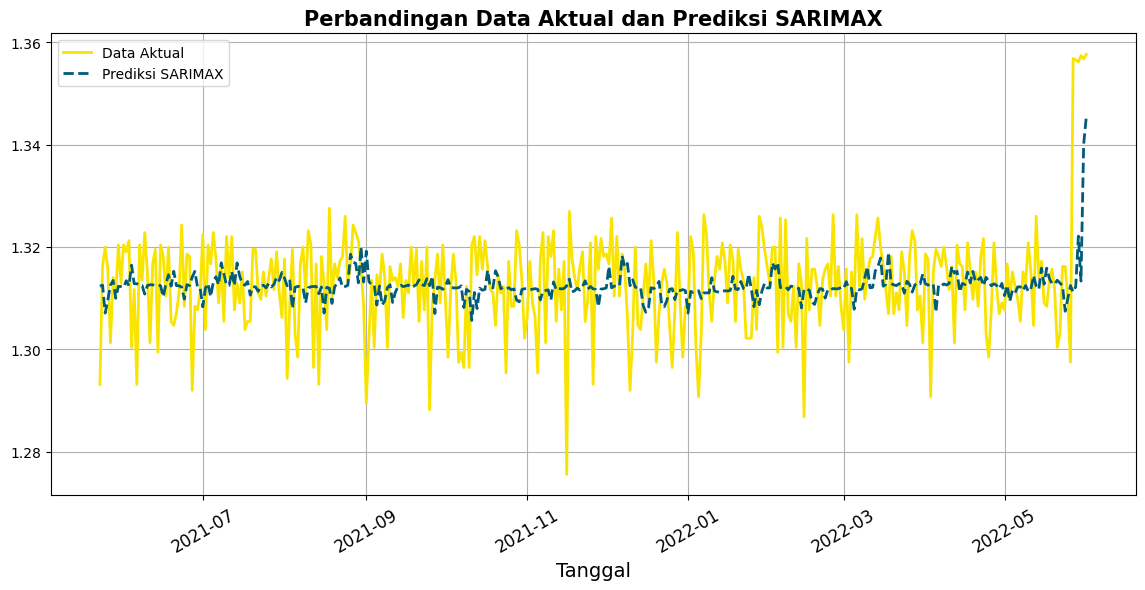

In [73]:
plt.figure(figsize=(14, 6))

# Plot data aktual
plt.plot(pred_df.index, pred_df['actual'], label='Data Aktual', color='#F9E400', linewidth=2)

# Plot prediksi SARIMAX
plt.plot(pred_df.index, pred_df['pred_SARIMAX'], label='Prediksi SARIMAX', color='#005C78', linestyle='--', linewidth=2)

# Tambahkan judul dan label
plt.title('Perbandingan Data Aktual dan Prediksi SARIMAX', fontsize=15, fontweight='bold')
plt.xlabel('Tanggal', fontsize=14)
plt.xticks(rotation=30, fontsize=12)
plt.legend()

# Tampilkan plot
plt.grid(True)
plt.show()

###**Prediksi**

In [74]:
# Tentukan rentang tanggal untuk prediksi

start_date = '2022-06-07'
end_date = '2024-12-31'
future_dates = pd.date_range(start=start_date, end=end_date, freq='D')

In [75]:
# Buat prediksi untuk periode di masa depan

forecast = best_model_fit.get_forecast(steps=len(future_dates))
predicted_mean = forecast.predicted_mean
conf_int = forecast.conf_int()

In [76]:
# Buat DataFrame untuk prediksi

pred_df = pd.DataFrame({
    'date': future_dates,
    'predicted_mean': predicted_mean
})
pred_df.set_index('date', inplace=True)

In [77]:
pred_df

,predicted_mean
date,
2022-06-07,1.312359
2022-06-08,1.312359
2022-06-09,1.312359
2022-06-10,1.312359
2022-06-11,1.312359
...,...
2024-12-27,1.312337
2024-12-28,1.312337
2024-12-29,1.312337


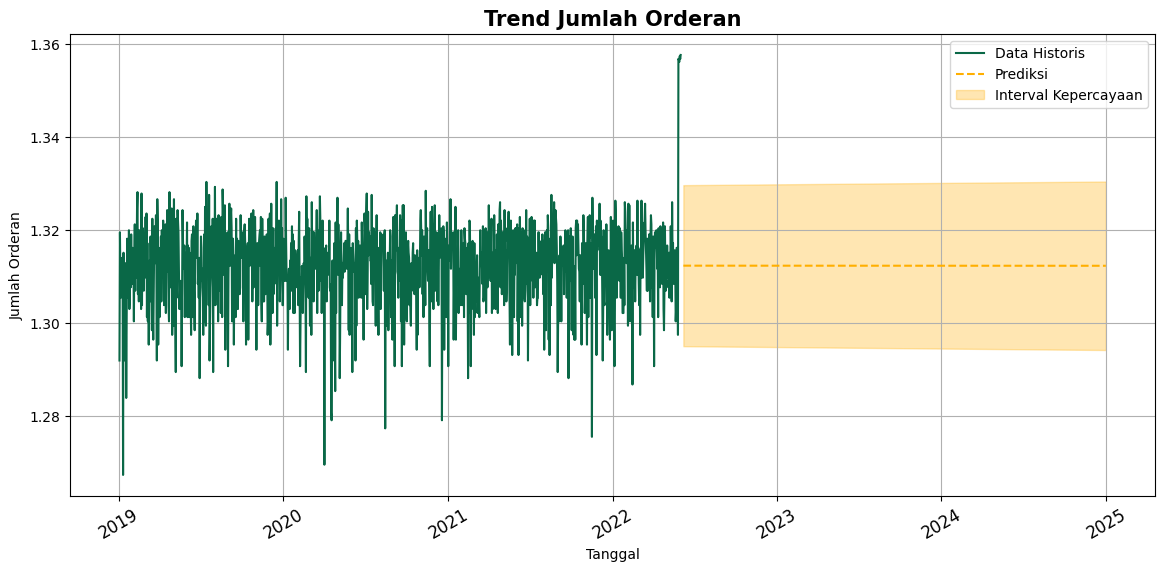

In [82]:
# Visualisasi hasil
plt.figure(figsize=(14, 6))

# Plot data historis
plt.plot(target.index, target, label='Data Historis', color='#0A6847')

# Plot prediksi
plt.plot(pred_df.index, pred_df['predicted_mean'], label='Prediksi', color='#FFAF00', linestyle='--')

# Plot interval kepercayaan
plt.fill_between(pred_df.index, conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='#FFAF00', alpha=0.3, label='Interval Kepercayaan')

# Tambahkan judul dan label
plt.title('Trend Jumlah Orderan', fontsize=15, fontweight='bold')
plt.xlabel('Tanggal')
plt.xticks(rotation=30, fontsize=12)
plt.ylabel('Jumlah Orderan')
plt.legend()
plt.grid(True)
plt.show()

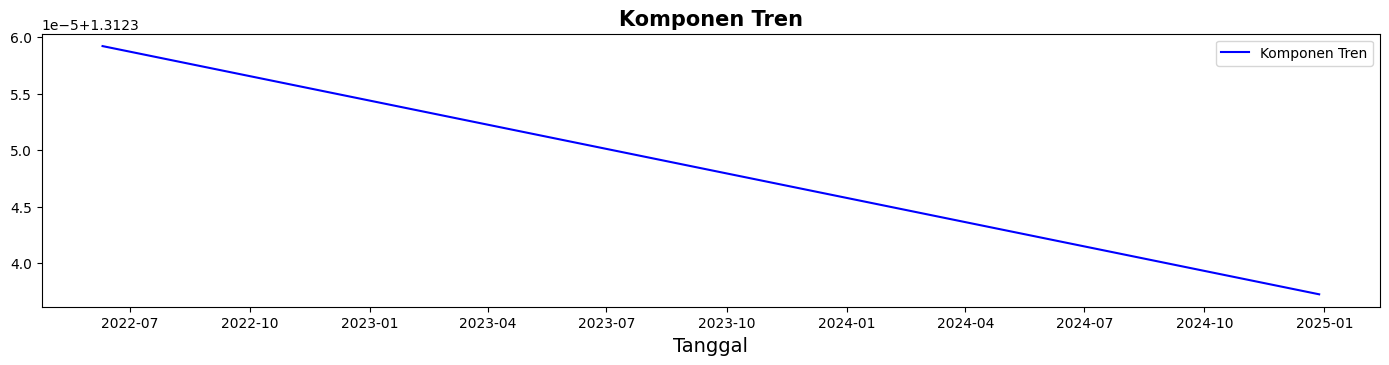

In [83]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Dekomposisi musiman pada data historis
decomposition = seasonal_decompose(pred_df['predicted_mean'], model='additive', period=s)

# Visualisasi komponen
plt.figure(figsize=(14, 10))

plt.subplot(3, 1, 1)
plt.plot(decomposition.trend, label='Komponen Tren', color='blue')
plt.legend(loc='best')
plt.title('Komponen Tren', fontsize=15, fontweight='bold')

plt.xlabel('Tanggal', fontsize=14)
plt.tight_layout()
plt.show()

Dari visualisasi tersebut dapat terlihat bahwa proyeksi jumlah orderan terus menurun (trend negatif).

In [84]:
# Tambahkan kolom hari dalam minggu
pred_df['day_of_week'] = pred_df.index.day_name()

# Agregasi total order per hari dalam minggu
weekly_sales = pred_df.groupby('day_of_week')['predicted_mean'].sum()

# Urutkan berdasarkan urutan hari dalam minggu
ordered_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
weekly_sales = weekly_sales.reindex(ordered_days)

print(weekly_sales)

day_of_week
Monday       175.854656
Tuesday      177.167013
Wednesday    175.854672
Thursday     175.854669
Friday       175.854666
Saturday     175.854663
Sunday       175.854660
Name: predicted_mean, dtype: float64


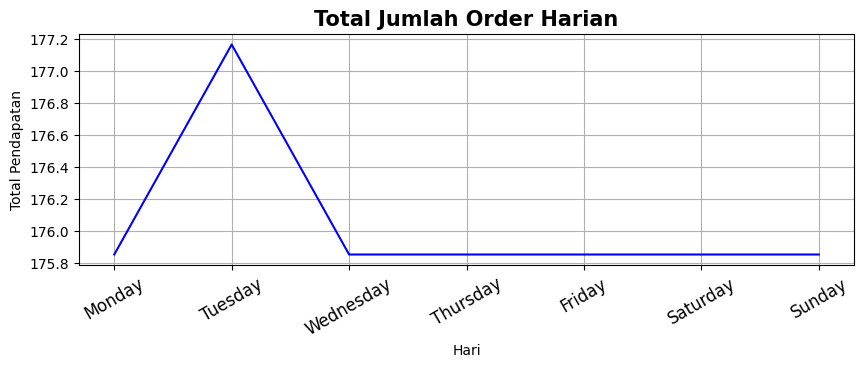

In [85]:
# Visualisasi total order per hari dalam minggu menggunakan plot garis
plt.figure(figsize=(10, 3))
plt.plot(weekly_sales.index, weekly_sales.values, linestyle='-', color='blue')

plt.title('Total Jumlah Order Harian', fontsize=15, fontweight='bold')
plt.xlabel('Hari')
plt.xticks(rotation=30, fontsize=12)
plt.ylabel('Total Pendapatan')
plt.grid(True)
plt.show()

Jumlah orderan terbanyak terjadi pada hari selasa.

In [86]:
# Tambahkan kolom bulan
pred_df['month'] = pred_df.index.month_name()

# Cek apakah kolom 'month' sudah ada dalam DataFrame
print(pred_df.head())

# Agregasi total order per bulan tanpa memperhitungkan tahun
monthly_sales = pred_df.groupby('month')['predicted_mean'].sum().reset_index()

# Urutkan berdasarkan urutan bulan dalam tahun
ordered_months = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
monthly_sales['month'] = pd.Categorical(monthly_sales['month'], categories=ordered_months, ordered=True)

# Urutkan berdasarkan bulan
monthly_sales = monthly_sales.sort_values('month')

print(monthly_sales)

            predicted_mean day_of_week month
date                                        
2022-06-07        1.312359     Tuesday  June
2022-06-08        1.312359   Wednesday  June
2022-06-09        1.312359    Thursday  June
2022-06-10        1.312359      Friday  June
2022-06-11        1.312359    Saturday  June
        month  predicted_mean
4     January       81.365684
3    February       74.803891
7       March       81.365597
0       April       78.740857
8         May       81.365508
6        June      110.237387
5        July      122.048528
1      August      122.048460
11  September      118.111348
10    October      122.048327
9    November      118.111219
2    December      122.048193


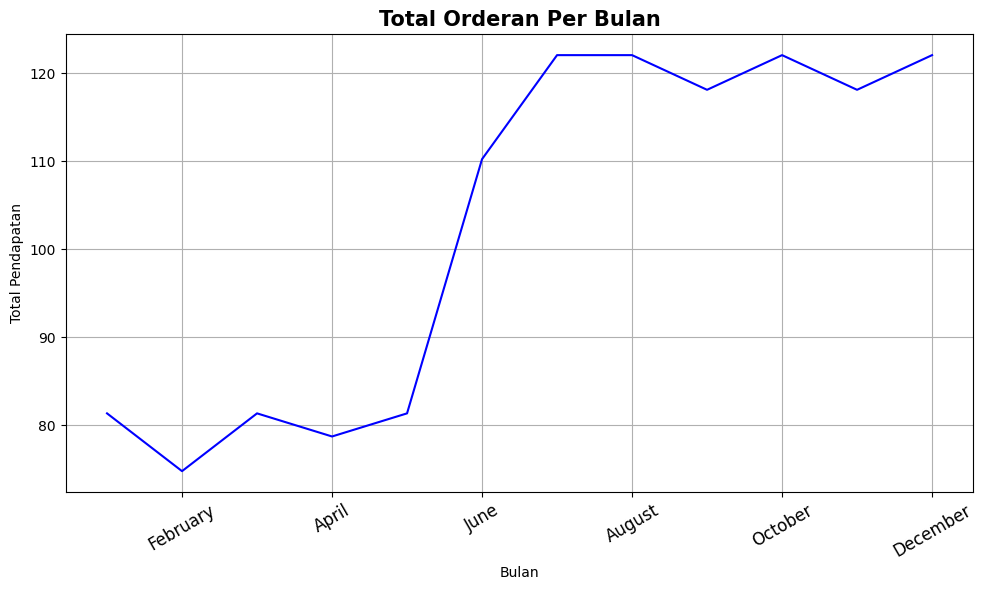

In [87]:
# Visualisasi total order per bulan menggunakan plot garis
plt.figure(figsize=(10, 6))

plt.plot(monthly_sales['month'], monthly_sales['predicted_mean'], linestyle='-', color='blue')

plt.title('Total Orderan Per Bulan', fontsize=15, fontweight='bold')
plt.xlabel('Bulan')
plt.ylabel('Total Pendapatan')

# Menampilkan setiap label ke-n (misalnya, setiap 2 bulan)
plt.xticks(ticks=range(1, len(monthly_sales['month']), 2), labels=monthly_sales['month'][1::2], rotation=30, fontsize=12)

plt.grid(True)
plt.tight_layout()
plt.show()

Lalu untuk bulan terbaik penjualan terjadi pada bulan Juli, Agustus, Oktober, dan Desember.

In [88]:
pred_df.head()

,predicted_mean,day_of_week,month
date,,,
2022-06-07,1.312359,Tuesday,June
2022-06-08,1.312359,Wednesday,June
2022-06-09,1.312359,Thursday,June
2022-06-10,1.312359,Friday,June
2022-06-11,1.312359,Saturday,June


In [89]:
from google.colab import files

pred_df.to_csv('Forecasting by order.csv', encoding = 'utf-8-sig')
files.download('Forecasting by order.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Kesimpulan**


Rencana perusahaan dalam melakukan ekspansi pasar dengan membuat cabang di negara lain layak untuk dilakukan. Adapun waktu yang disarankan adalah pada akhir tahun yaitu antara bulan Oktober dan November dengan hari launching yang disarankan adalah hari selasa. Negara yang layak menjadi tujuan ekspansi pasar adalah negara China dikarenakan transaksi tertinggi berasal dari negara tersebut. Selain itu China dekat dengan korea selatan yang termasuk 5 negara dengan transaksi tertinggi dan merupakan kiblat fashion asia. Kemudian, diharapkan akan mempermudah pengiriman barang disekitar Asia sehingga dapat mengurangi Shipping cost dan mengurangi presentase return akibat barang rusak di jalan. Dengan ekspansi pasar ke China maka divisi sales optimis akan mempercepat laju pertumbuhan perusahaan di kancah global.

